In [2]:
# 利用w2v提取金额特征的embedding，作为特征加入训练。
import os
import pandas as pd
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import pandas as pd
import numpy as np
import multiprocessing

L = 10

path = './'
save_path = path + '/w2v'
if not os.path.exists(save_path):
    print(save_path)
    os.makedirs(save_path)

train = pd.read_csv('./data/train_stage2_update_20200320.csv')
test = pd.read_csv('./data/test_stage2_update_20200320.csv')

# 将异常值改为None,避免模型学到异常信息造成过拟合
train.loc[train['注册资本']>10000, '注册资本'] = None
train.loc[train['其他应收款_年末数']>400000, '其他应收款_年末数'] = None
train.loc[train['其他应收款_年末数']>400000, '其他应收款_年末数'] = None
train.loc[train['流动资产合计_年末数']<0, '流动资产合计_年末数'] = None
train.loc[train['其他应收款_年初数']<0, '其他应收款_年初数'] = None
train.loc[train['流动资产合计_年初数']<0, '流动资产合计_年初数'] = None
train.loc[train['其他应收款_年末数']<0, '其他应收款_年末数'] = None

test.loc[test['企业所得税']>7000, '企业所得税'] = None
test.loc[test['城建税']>300, '城建税'] = None
test.loc[test['增值税']>5000, '增值税'] = None
test.loc[test['教育费']>140, '教育费'] = None

data = pd.concat([train, test]).reset_index(drop=True).sample(frac=1, random_state=2018).fillna(0)
sentence = []
for line in list(data[['企业所得税','城建税','增值税','印花税','教育费','年度参保总额',
            '货币资金_年末数','注册资本','货币资金_年初数',
            '投资总额','其他应收款_年末数','流动资产合计_年初数','其他应收款_年初数','流动资产合计_年末数',
            '固定资产合计_年初数','未分配利润_年末数','非流动资产合计_年初数']].values):
    sentence.append([str(float(l)) for idx, l in enumerate(line)])

print('training...')
model = Word2Vec(sentence, size=L, window=2, min_count=1, workers=multiprocessing.cpu_count(),
                 iter=10)
print('outputing...')

for fea in ['企业所得税','城建税','增值税','印花税','教育费','年度参保总额',
            '货币资金_年末数','注册资本','货币资金_年初数',
            '投资总额','其他应收款_年末数','流动资产合计_年初数','其他应收款_年初数','流动资产合计_年末数',
            '固定资产合计_年初数','未分配利润_年末数','非流动资产合计_年初数']:
    values = []
    for line in list(data[fea].values):
        values.append(line)
    values = set(values)
    print(len(values))
    w2v = []
    for i in values:
        a = [i]
        a.extend(model[str(float(i))])
        w2v.append(a)
    out_df = pd.DataFrame(w2v)

    name = [fea]
    for i in range(L):
        name.append(name[0] + 'W' + str(i))
    out_df.columns = name
    out_df.to_csv(save_path + '/' + fea + '.csv', index=False)

ModuleNotFoundError: No module named 'gensim'

D:\anaconda\lib\site-packages\ipykernel_launcher.py:19: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


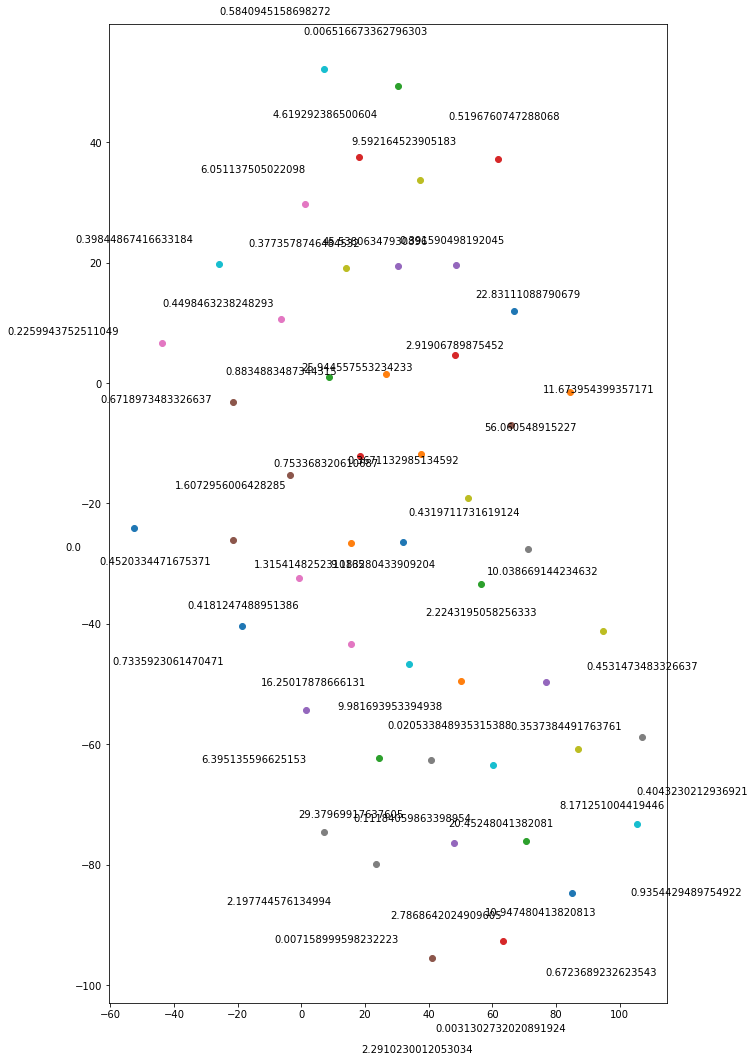

In [9]:
# w2v结果可视化，由可视化结果可以看出来w2v效果一般
import pandas as pd
import multiprocessing
import numpy as np
import random
import sys
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
df=pd.read_csv('./w2v/教育费.csv')
l=list(df['教育费'].astype('str'))
name=list(df)

def plot_with_labels(low_dim_embs, labels, filename = 'tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize= (10, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy = (x, y), textcoords = 'offset points', ha = 'right', va = 'bottom')
    plt.savefig(filename) 

tsne = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 5000)

plot_only = 50
low_dim_embs = tsne.fit_transform(df.iloc[:plot_only][name[1:]])
labels = [l[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)